In [1]:
import xarray as xr

In [31]:
# load data
data_dir = '/data/segmentation/20200227_IF_Training/'
# cohort_xr = xr.load_dataarray(data_dir + 'Test_Points_Immune_Only.nc')
cohort_xr = xr.open_dataarray(data_dir + 'cHL_input.xr')

In [3]:
import os
import errno
import numpy as np 
import deepcell

In [11]:
# load previously trained model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5")

In [12]:
from deepcell_toolbox.utils import tile_image

In [32]:
test_data, test_info = tile_image(cohort_xr.values, (256, 256), stride_ratio=0.5)

In [33]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = model.predict(test_data)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (336, 256, 256, 1) in 3.1223983690006207 seconds.


In [34]:
inner_distance, outer_distance, fgbg, pixelwise = test_images

In [16]:
def untile_image(tiles, tiles_info, dtype,
                 model_input_shape=(512, 512)):
    """Untile a set of tiled images back to the original model shape.
    Args:
        tiles (numpy.array): The tiled images image to untile.
        tiles_info (dict): Details of how the image was tiled (from tile_image).
        model_input_shape (tuple): The input size of the model.
    Returns:
        numpy.array: The untiled image.
    """
    _axis = 1
    image_shape = tiles_info['image_shape']
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = tuple(list(image_shape[0:3]) + [tiles.shape[-1]])
    image = np.zeros(image_shape, dtype=dtype)

    zipped = zip(tiles, batches, x_starts, x_ends, y_starts, y_ends)
    for tile, batch, x_start, x_end, y_start, y_end in zipped:
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start != 0:
            x_start += (tile_size_x - stride_x) / 2
            tile_x_start += (tile_size_x - stride_x) / 2
        if x_end != image_shape[_axis]:
            x_end -= (tile_size_x - stride_x) / 2
            tile_x_end -= (tile_size_x - stride_x) / 2
        if y_start != 0:
            y_start += (tile_size_y - stride_y) / 2
            tile_y_start += (tile_size_y - stride_y) / 2
        if y_end != image_shape[_axis]:
            y_end -= (tile_size_y - stride_y) / 2
            tile_y_end -= (tile_size_y - stride_y) / 2

        x_start = np.int(x_start)
        x_end = np.int(x_end)
        y_start = np.int(y_start)
        y_end = np.int(y_end)

        tile_x_start = np.int(tile_x_start)
        tile_x_end = np.int(tile_x_end)
        tile_y_start = np.int(tile_y_start)
        tile_y_end = np.int(tile_y_end)

        image[batch, x_start:x_end, y_start:y_end, :] = \
            tile[tile_x_start:tile_x_end, tile_y_start:tile_y_end, :]

    return image

In [35]:
inner_distance_untile = untile_image(inner_distance, test_info, "float32", (256, 256))

In [36]:
outer_distance_untile = untile_image(outer_distance, test_info, "float32",(256, 256))

In [37]:
pixelwise_untile = untile_image(pixelwise, test_info, "float32", (256, 256))

In [38]:
combined = np.concatenate((pixelwise_untile[:, :, :, 1:2], inner_distance_untile, outer_distance_untile), axis=-1)
combined.shape

(1, 2080, 2784, 3)

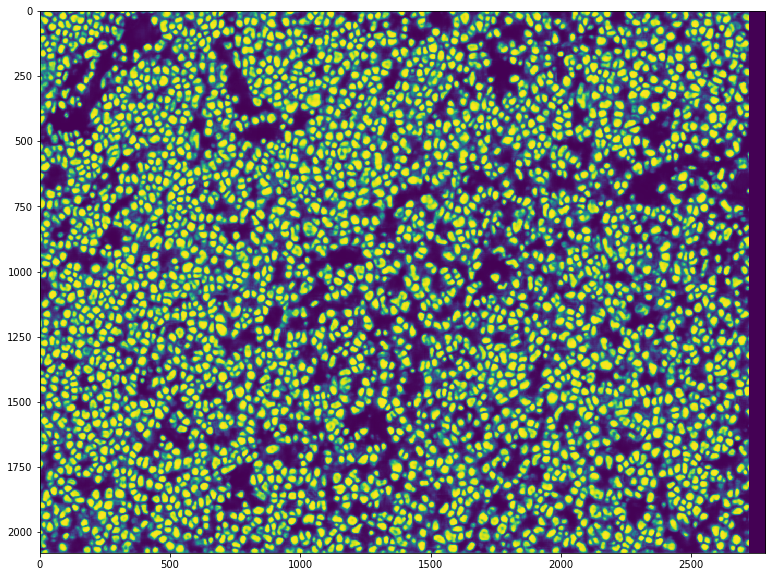

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(combined[0, :, :, 0])

In [22]:
model_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'watershed_inner', 'watershed_outer']],
                         dims=['points', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deep_watershed_v5_points_output.xr"), format="NETCDF4")